# **Belvedere stereo matching**

 v0.1 2022.05.17

In [1]:
import numpy as np
import os
from pathlib import Path
import cv2 
import pydegensac
import pickle
from copy import deepcopy
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import open3d as o3d

from src.match_pairs import match_pair
from src.track_matches import track_matches
# from src.sg.utils import make_matching_plot

from src.io import read_img
from src.geometry import (estimate_pose, P_from_KRT, X0_from_P, project_points)
from src.utils import (normalize_and_und_points, draw_epip_lines, make_matching_plot, undistort_image, interpolate_point_colors, build_dsm)
from src.thirdParts.triangulation import (linear_LS_triangulation, iterative_LS_triangulation)

#  Parameters (to be put in parser)

rootDirPath = '.'

#- Folders and paths
imFld = 'data/img'
imExt = '.tif'
calibFld = 'data/calib'

#- CAMERAS
numCams = 2
camNames = ['p2', 'p3']

#- Image cropping boundaries
maskBB = [[600,1900,5300, 3600], [800,1800,5500,3500]]             # Bounding box for processing the images from the two cameras

#  Load data
cameras = []  # List for storing cameras information (as dicts)
images = []   # List for storing image paths
features = []  # Dict for storing all the valid matched features at all epochs
F = [] # List for storing fundamental matrixes
points3d = [] # List for storing 3D points

#- images
for jj, cam in enumerate(camNames):
    d  = os.listdir(os.path.join(rootDirPath, imFld, cam))
    for i, f in enumerate(d):
        d[i] = os.path.join(rootDirPath, imFld, cam, f)
    d.sort()
    if jj > 0 and len(d) is not len(images[jj-1]):
        print('Error: different number of images per camera')
    else:
        images.insert(jj, d)
# TODO: change order of epoches and cameras to make everything consistent!
        
#- Cameras structures
# TO DO: implement camera class!
for jj, cam in enumerate(camNames):
    path = (os.path.join(rootDirPath, calibFld, cam+'.txt'))
    with open(path, 'r') as f:
        data = np.loadtxt(f)
    K = data[0:9].astype(float).reshape(3, 3, order='C')
    dist = data[9:13].astype(float)
    cameras.insert(jj, {'K': K, 'dist': dist})

# Remove some variables
del d, data, K, dist, path, f, i, jj

print('Data loaded')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Data loaded


# **Process epoches** 

In [2]:
find_matches = 0
if find_matches:
    epoches2process = [0,1] # #1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


    for epoch in epoches2process:
        print(f'Processing epoch {epoch}...')

        #=== Find Matches at current epoch ===#
        print('Run Superglue to find matches at epoch {}'.format(epoch))    
        epochdir = os.path.join('res','epoch_'+str(epoch))      
        pair = [images[0][epoch], images[1][epoch]]
        maskBB = np.array(maskBB).astype('int')
        opt_matching ={'output_dir': epochdir, 

                       'resize': [-1],
                       'resize_float': True,
                       'equalize_hist': False,

                       'nms_radius': 3,  # default 3 
                       'keypoint_threshold': 0.0001, 
                       'max_keypoints': 7000, #4096, # Use 8192 for returning more matches

                       'superglue': 'outdoor',
                       'sinkhorn_iterations': 100,
                       'match_threshold': 0.2, 

                       'viz':  True,
                       'viz_extension': 'png', 
                       'fast_viz': True,
                       'opencv_display' : False, 
                       'show_keypoints': False, 

                       'cache': False,
                       'force_cpu': False,

                       'useTile': True, 
                       'writeTile2Disk': False,
                       'do_viz_tile': False,
                       'rowDivisor': 2,
                       'colDivisor': 3,
                       'overlap': 300,            
                       }
        matchedPts, matchedDescriptors, matchedPtsScores, _ = match_pair(pair, maskBB, opt_matching)

        # Store matches in features structure
        if epoch == 0:
            features = [{   'mkpts0': matchedPts['mkpts0'], 
                            'mkpts1': matchedPts['mkpts1'],
                            # 'mconf': matchedPts['match_confidence'],
                            'descr0': matchedDescriptors[0], 
                            'descr1': matchedDescriptors[1],
                            'scores0': matchedPtsScores[0], 
                            'scores1': matchedPtsScores[1] }] 
        # TODO: Store match confidence!

        #=== Track previous matches at current epoch ===#
        if epoch > 0:
            print('Track points from epoch {} to epoch {}'.format(epoch-1, epoch))

            trackoutdir = os.path.join('res','epoch_'+str(epoch), 'from_t'+str(epoch-1))
            pairs = [ [ images[0][epoch-1], images[0][epoch] ], 
                      [ images[1][epoch-1], images[1][epoch] ] ] 
            maskBB = np.array(maskBB).astype('int')
            opt_tracking = {'output_dir': trackoutdir,

                            'resize': [-1],
                            'resize_float': True,
                            'equalize_hist': False,

                            'nms_radius': 4 , 
                            'keypoint_threshold': 0.0001, 
                            'max_keypoints': 8192, 

                            'superglue': 'outdoor',
                            'sinkhorn_iterations': 100,
                            'match_threshold': 0.2, 

                            'viz':  True,
                            'viz_extension': 'png',  
                            'fast_viz': True,
                            'opencv_display' : False, 
                            'show_keypoints': False, 

                            'cache': False,
                            'force_cpu': False,

                            'useTile': True, 
                            'writeTile2Disk': False,
                            'do_viz_tile': False,
                            'rowDivisor': 2,
                            'colDivisor': 4,
                               }   

            prevs = [{'keypoints0': np.float32(features[epoch-1]['mkpts0']), 
                      'descriptors0': np.float32(features[epoch-1]['descr0']),
                      'scores0': np.float32(features[epoch-1]['scores0']) }, 
                     {'keypoints0': np.float32(features[epoch-1]['mkpts1']), 
                      'descriptors0': np.float32(features[epoch-1]['descr1']), 
                      'scores0': np.float32(features[epoch-1]['scores1'])  }  ]
            tracked_cam0, tracked_cam1 = track_matches(pairs, maskBB, prevs, opt_tracking)
            # TO DO: tenere traccia anche dei descriptors and scores dei punti traccati!
            # TO DO: tenere traccia dell'epoca in cui è stato trovato il match
            # TO CHECK: Problema nei punti tracciati... vengono rigettati da pydegensac

            # Store all matches in features structure
            features.append({'mkpts0': np.concatenate((matchedPts['mkpts0'], tracked_cam0['keypoints1']), axis=0 ), 
                             'mkpts1': np.concatenate((matchedPts['mkpts1'], tracked_cam1['keypoints1']), axis=0 ),
                             # 'mconf': matchedPts['match_confidence'],
                              'descr0': np.concatenate((matchedDescriptors[0], tracked_cam0['descriptors1']), axis=1 ),
                              'descr1': np.concatenate((matchedDescriptors[1], tracked_cam1['descriptors1']), axis=1 ),
                              'scores0': np.concatenate((matchedPtsScores[0], tracked_cam0['scores1']), axis=0 ), 
                              'scores1': np.concatenate((matchedPtsScores[1], tracked_cam1['scores1']), axis=0 ), 
                             })

            # Run Pydegensac to estimate F matrix and reject outliers                         
            F[epoch], inlMask = pydegensac.findFundamentalMatrix(features[epoch]['mkpts0'], features[epoch]['mkpts1'], px_th=3, conf=0.9,
                                                          max_iters=100000, laf_consistensy_coef=-1.0, error_type='sampson',
                                                          symmetric_error_check=True, enable_degeneracy_check=True)
            print('Matches at epoch {}: pydegensac found {} inliers ({:.2f}%)'.format(epoch, int(deepcopy(inlMask).astype(np.float32).sum()),
                            int(deepcopy(inlMask).astype(np.float32).sum())*100 / len(features[epoch]['mkpts0'])))

        # Write matched points to disk   
        stem0, stem1 = Path(images[0][epoch]).stem, Path(images[1][epoch]).stem
        np.savetxt(os.path.join(epochdir, stem0+'_matchedPts.txt'), 
                   features[epoch]['mkpts0'] , fmt='%i', delimiter=',', newline='\n',
                   header='x,y') 
        np.savetxt(os.path.join(epochdir, stem1+'_matchedPts.txt'), 
                   features[epoch]['mkpts1'] , fmt='%i', delimiter=' ', newline='\n',                   
                   header='x,y') 
        with open(os.path.join(epochdir, stem0+'_'+stem1+'_features.pickle'), 'wb') as f:
            pickle.dump(features, f, protocol=pickle.HIGHEST_PROTOCOL)

    print('Matching completed')

else: 
    epoch = 0
    if not features:
        matches_path = 'res/epoch_0/IMG_0520_IMG_2131_features.pickle'
        with open(matches_path, 'rb') as f:
            features = pickle.load(f)

# **SfM**

### Realtive Pose with Essential Matrix

In [3]:
pts0, pts1 = features[0]['mkpts0'], features[0]['mkpts1']
rel_pose = estimate_pose(pts0, pts1, cameras[0]['K'],  cameras[1]['K'], thresh=1, conf=0.99999)
R = rel_pose[0]
t = rel_pose[1]
valid = rel_pose[2]
print('Computing relative pose. Valid points: {}/{}'.format(valid.sum(),len(valid)))

# Build cameras structures
cameras[0]['R'], cameras[0]['t'] = np.eye(3), np.zeros((3,1))
cameras[1]['R'], cameras[1]['t'] = R, t.reshape(3,1)
for jj in range(0,numCams):
    cameras[jj]['P'] = P_from_KRT(cameras[jj]['K'], cameras[jj]['R'], cameras[jj]['t'])
    cameras[jj]['X0'] = X0_from_P(cameras[jj]['P'])

# Scale model by using camera baseline
X01_meta = np.array([416651.52489669225,5091109.91215075,1858.908434299682])   # IMG_2092
X02_meta = np.array([416622.27552777925,5091364.507128085,1902.4053286545502]) # IMG_0481
camWorldBaseline = np.linalg.norm(X01_meta - X02_meta)                         # [m] From Metashape model at epoch t0
camRelOriBaseline = np.linalg.norm(cameras[0]['X0'] - cameras[1]['X0'])
scaleFct = camWorldBaseline / camRelOriBaseline
cameras[1]['X0'] =  cameras[1]['X0'] * scaleFct
cameras[1]['t'] = -np.matmul(cameras[1]['R'], cameras[1]['X0'])
cameras[1]['P'] = P_from_KRT(cameras[1]['K'], cameras[1]['R'], cameras[1]['t'])

Computing relative pose. Valid points: 3224/5018


### Trinagulate points

In [5]:
pts0_und = cv2.undistortPoints(features[0]['mkpts0'], cameras[0]['K'], cameras[0]['dist'], None, cameras[0]['K'])
pts1_und = cv2.undistortPoints(features[0]['mkpts1'], cameras[1]['K'], cameras[1]['dist'], None, cameras[1]['K'])
M, status = iterative_LS_triangulation(pts0_und, cameras[0]['P'],  pts1_und, cameras[1]['P'])
points3d.insert(epoch, M)
print(f'Triangulated success: {status.sum()/status.size}')

# Interpolate colors from image 
jj = 1
image = cv2.cvtColor(cv2.imread(images[jj][0], flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
points3d_cols =  interpolate_point_colors(points3d[0], image, cameras[jj]['K'], cameras[jj]['R'], cameras[jj]['t'], cameras[jj]['dist'])
#TODO: check why function doesn't work with image 1!

# Visualize and export sparse point cloud
do_viz = False

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d[epoch])
pcd.colors = o3d.utility.Vector3dVector(points3d_cols)
o3d.io.write_point_cloud("res/epoch_0/sparsepts_t"+str(epoch)+".ply", pcd)
if do_viz:
    o3d.visualization.draw_geometries([pcd])


Triangulated success: 1.0


In [89]:
## Build approximate DSM
dsm = build_dsm(points3d[epoch], dsm_step=0.1, save_path="dsm_approx.tif")

In [110]:
# Generate Ortophotos
from scipy.interpolate import (interp2d)
from src.geometry import (P_from_KRT, project_points)

def interpolate_point_colors2(pointxyz, image, P, K=None, dist=None, winsz=1):
    ''''
    Interpolate color of a 3D sparse point cloud, given an oriented image
      Inputs:  
       - Nx3 matrix with 3d world points coordinates
       - image
       - camera interior and exterior orientation matrixes: K, R, t
       - distortion vector according to OpenCV
    Output: Nx3 colour matrix, as float numbers (normalized in [0,1])
    '''
    assert K is not None, 'invalid camera matrix' 
    assert R is not None, 'invalid rotation matrix' 
    assert t is not None, 'invalid translation vector' 
    assert image.ndim == 3, 'invalid input image. Image has not 3 channel'

    if K is not None and dist is not None:
        image = cv2.undistort(image, K, dist, None, K)
    
    numPts = len(pointxyz)
    col = np.zeros((numPts,3))
    h,w,_ = image.shape
    # P = P_from_KRT(K, R, t)
    projections = project_points(pointxyz, P, K, dist)
    image = image.astype(np.float32) / 255.
    
    for k, m in enumerate(projections):
        kint = np.round(m).astype(int)
        i = np.array([a for a in range(kint[1]-winsz,kint[1]+winsz+1)])
        j = np.array([a for a in range(kint[0]-winsz,kint[0]+winsz+1)])
        if i.min()<0 or i.max()>h or j.min()<0 or j.max()>w:
            continue
        ii, jj = np.meshgrid(i,j)
        ii, jj = ii.flatten(), jj.flatten()
        for rgb in range(0,3):
            colPatch = image[i[0]:i[-1]+1,j[0]:j[-1]+1,rgb]
            fcol = interp2d(i, j, colPatch, kind='linear')  
            col[k,rgb] = fcol(m[k,0], m[k,1])
    return col

def generate_ortophoto(image, dsm, P, res=1):
    xx = dsm.x
    yy = dsm.y
    zz = dsm.z
    
    dsm_shape = dsm.x.shape
    ncell = dsm_shape[0]*dsm_shape[1]
    xyz = np.zeros((ncell,3))
    xyz[:,0] = xx.flatten()
    xyz[:,1] = yy.flatten()
    xyz[:,2] = zz.flatten()
    valid_cell = np.invert(np.isnan(xyz[:,2]))
    
    cols = np.full((ncell,3),0)
    cols[valid_cell,:] = interpolate_point_colors2(xyz[valid_cell,:], image, camera['P'], camera['K'], camera['dist'])
    ortophoto = np.zeros((dsm_shape[0],dsm_shape[1],3))
    ortophoto[:,:,0] = cols[:,0].reshape(dsm_shape[0], dsm_shape[1])
    ortophoto[:,:,1] = cols[:,1].reshape(dsm_shape[0], dsm_shape[1])
    ortophoto[:,:,2] = cols[:,2].reshape(dsm_shape[0], dsm_shape[1])
    ortophoto = np.uint8(ortophoto*255)
    
    # for a, b, c in zip(xx.flatten(), yy.flatten(), zz.flatten()):
    #     xyz.append([a, b, c]) 
    # ortophoto = cols[:,0].reshape(dsm_shape[0], dsm_shape[1],3)
    # ortophoto = np.uint8(ortophoto*255)

    return xyz, cols, ortophoto

    
    # ortophoto = None
    # return ortophoto


[2029.73629085 2674.10090027]
[2673 2674 2675] [2029 2030 2031]


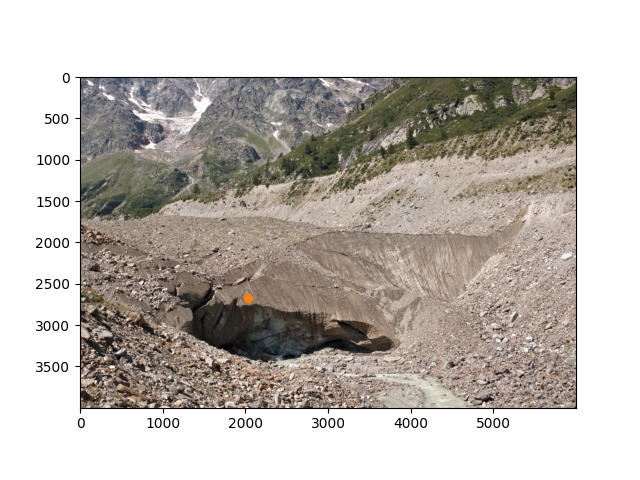

In [139]:
jj = 1
pointxyz = points3d[0]
image = cv2.cvtColor(cv2.imread(images[jj][0], flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
P,K,dist = cameras[jj]['P'], cameras[jj]['K'], cameras[jj]['dist']
winsz = 1


h,w,_ = image.shape
# P = P_from_KRT(K, R, t)
projections = project_points(pointxyz, P, K, dist)
image = image.astype(np.float32) / 255.
projections = projections[1:10,:]


numPts = len(projections)
col = np.zeros((numPts,3))
k = 0
m = projections[k]
print(m)
kint = np.round(m).astype(int)
i = np.array([a for a in range(kint[1]-winsz,kint[1]+winsz+1)])
j = np.array([a for a in range(kint[0]-winsz,kint[0]+winsz+1)])
print(i,j)
if i.min()<0 or i.max()>h or j.min()<0 or j.max()>w:
    print('err')

plt.imshow(np.uint8(image*255))    
plt.scatter(m[0],m[1])
plt.show()

# ii, jj = np.meshgrid(i,j)
# ii, jj = ii.flatten(), jj.flatten()
# for rgb in range(0,3):
#     colPatch = image[i[0]:i[-1]+1,j[0]:j[-1]+1,rgb]
#     fcol = interp2d(i, j, colPatch, kind='linear')  
#     col[k,rgb] = fcol(m[k,0], m[k,1])

# for k, m in enumerate(projections):
#     kint = np.round(m).astype(int)
#     i = np.array([a for a in range(kint[1]-winsz,kint[1]+winsz+1)])
#     j = np.array([a for a in range(kint[0]-winsz,kint[0]+winsz+1)])
#     if i.min()<0 or i.max()>h or j.min()<0 or j.max()>w:
#         continue
#     ii, jj = np.meshgrid(i,j)
#     ii, jj = ii.flatten(), jj.flatten()
#     for rgb in range(0,3):
#         colPatch = image[i[0]:i[-1]+1,j[0]:j[-1]+1,rgb]
#         fcol = interp2d(i, j, colPatch, kind='linear')  
#         col[k,rgb] = fcol(m[k,0], m[k,1])

In [113]:
jj = 1
image = cv2.cvtColor(cv2.imread(images[jj][0], flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
points3d_cols =  interpolate_point_colors2(points3d[0], image, cameras[jj]['P'], cameras[jj]['K'], cameras[jj]['dist'])
print(points3d_cols)

[0 0 0]


In [7]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d[epoch])
pcd.colors = o3d.utility.Vector3dVector(points3d_cols)
if do_viz:
    o3d.visualization.draw_geometries([pcd])

In [100]:
image = cv2.cvtColor(cv2.imread(images[1][0], flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
xyz, cols, ortophoto = generate_ortophoto(image, dsm, cameras[1])


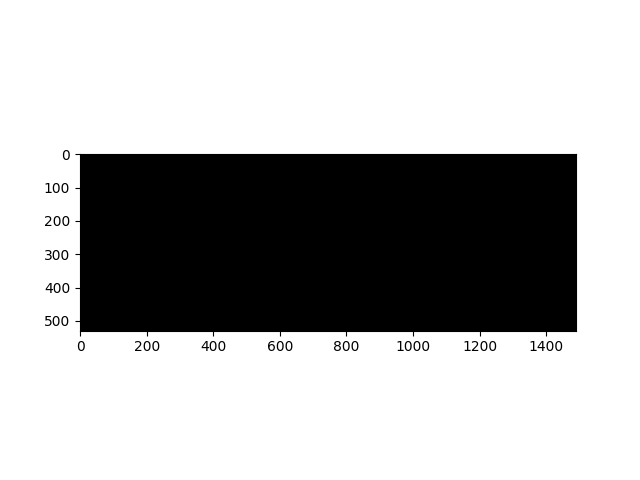

In [96]:
# print(cols.shape)
# print(dsm.x.shape)
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt

ax = plt.figure()
im = plt.imshow(ortophoto)
# scatter = plt.scatter(x, y, 1, c='k', alpha=0.5, marker='.')
# plt.gca().invert_yaxis()
# cbar = plt.colorbar(im)
# cbar.set_label("z")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()
# plt.savefig('dsm_approx_plt.png', bbox_inches='tight')

In [ ]:
if np.any(np.array(points3d[0].shape) == 3):
    print('a')
print(points3d[0].shape[0])
a = np.array([[0,0,0], [0,0,0], [0,0,0]])
a.shape
if a.shape[0] == a.shape[1]:
    print("aa")

b = points3d[0].T
print(b.shape)

## DENSE MATCHING

In [7]:
sgm_path = Path('sgm')
downsample = 0.25
fast_viz = True

stem0 = Path(images[0][0]).stem
stem1 = Path(images[1][0]).stem

pts0, pts1 = features[0]['mkpts0'], features[0]['mkpts1']
F, inlMask = pydegensac.findFundamentalMatrix(pts0, pts1, px_th=1, conf=0.99999,
                                              max_iters=100000, laf_consistensy_coef=-1.0, error_type='sampson',
                                              symmetric_error_check=True, enable_degeneracy_check=True)

img0 = cv2.imread(images[0][0], flags=cv2.IMREAD_COLOR)
img1 = cv2.imread(images[1][0], flags=cv2.IMREAD_COLOR)
h, w, _ = img0.shape


In [12]:
## Rectify calibrated
R1,R2,P1,P2,Q = cv2.stereoRectify(cameras[0]['K'], cameras[0]['dist'], cameras[1]['K'], cameras[1]['dist'],\
             (h,w), cameras[1]['R'], cameras[1]['t'])

ValueError: too many values to unpack (expected 5)

In [7]:
## Recify Uncalibrated

# undistort images
name0 = str(sgm_path / 'und' / (stem0 + "_undistorted.jpg"))
name1 = str(sgm_path / 'und' / (stem1 + "_undistorted.jpg"))
img0, K0_scaled = undistort_image(img0, cameras[0]['K'],  cameras[0]['dist'], downsample, name0)
img1, K1_scaled = undistort_image(img1, cameras[1]['K'],  cameras[1]['dist'], downsample, name1)

# Rectify uncalibrated
pts0, pts1 = features[0]['mkpts1']*downsample, features[0]['mkpts0']*downsample
F, inlMask = pydegensac.findFundamentalMatrix(pts0, pts1, px_th=1, conf=0.99999,
                                              max_iters=100000, laf_consistensy_coef=-1.0, error_type='sampson',
                                              symmetric_error_check=True, enable_degeneracy_check=True)
print('Pydegensac: {} inliers ({:.2f}%)'.format(inlMask.sum(), inlMask.sum()*100 / len(pts0)))
success, H1, H0 = cv2.stereoRectifyUncalibrated(pts0, pts1 , F, (w,h))
img0_rectified = cv2.warpPerspective(img0, H0, (w,h))
img1_rectified = cv2.warpPerspective(img1, H1, (w,h))

# write images to disk
path0 = str(sgm_path / 'rectified' / (stem0 + "_rectified.jpg"))
path1 = str(sgm_path / 'rectified' / (stem1 + "_rectified.jpg"))
cv2.imwrite(path0, img0_rectified)
cv2.imwrite(path1, img1_rectified)

if fast_viz: 
else:
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img0_rectified, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB))
    plt.show()

Pydegensac: 5018 inliers (100.00%)


In [ ]:
# Run PSMNet to compute disparity


In [ ]:
# Find epilines corresponding to points in right image (second image) and drawing its lines on left image
img0 = cv2.imread(images[0][0], flags=cv2.IMREAD_COLOR)
img1 = cv2.imread(images[1][0], flags=cv2.IMREAD_COLOR)

lines0 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, F)
lines0 = lines0.reshape(-1,3)
img0_epiplines, _ = draw_epip_lines(img0,img1,lines0,pts0,pts1)

# Find epilines corresponding to points in left image (first image) and drawing its lines on right image
lines1 = cv2.computeCorrespondEpilines(pts0.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img1_epiplines,_ = draw_epip_lines(img1,img0,lines1,pts1,pts0, fast_viz=True)

if fast_viz:
    cv2.imwrite(str(sgm_path / (stem0 + "_epiplines.jpg")), img0_epiplines)
    cv2.imwrite(str(sgm_path / (stem1 + "_epiplines.jpg")), img1_epiplines)
else: 
    plt.subplot(121),plt.imshow(img0_epiplines)
    plt.subplot(122),plt.imshow(img1_epiplines)
    plt.show()

In [ ]:
# Draw keypoints and matches
pts0_rect = cv2.perspectiveTransform(np.float32(pts0).reshape(-1,1,2), H0).reshape(-1,2)
pts1_rect = cv2.perspectiveTransform(np.float32(pts1).reshape(-1,1,2), H1).reshape(-1,2)

# img0_rect_kpts = img0.copy()
img0 = cv2.imread(images[0][0], flags=cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(images[1][0], flags=cv2.IMREAD_GRAYSCALE)
pts0, pts1 = features[0]['mkpts0'], features[0]['mkpts1']
img0_kpts = cv2.drawKeypoints(img0,cv2.KeyPoint.convert(pts0),img0,(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img1_kpts = cv2.drawKeypoints(img1,cv2.KeyPoint.convert(pts1),img1,(0,0,255),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('kpts0.jpg', img0_kpts)
cv2.imwrite('kpts1.jpg', img1_kpts)

make_matching_plot(img0, img1, pts0, pts1, path='matches.jpg')    

In [ ]:
# # SGM OPENCV
# blockSize = 5
# min_disp = 128
# max_disp = 512
# num_disp = max_disp-min_disp
# stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#     numDisparities = num_disp,
#     blockSize = blockSize,
#     P1 = 8*1*blockSize**2,
#     P2 = 32*1*blockSize**2,
#     disp12MaxDiff = 0,
#     uniquenessRatio = 5,
#     speckleWindowSize = 100,
#     speckleRange = 2,
# )

# imgR = img0_rectified
# imgL = img1_rectified
# print('computing disparity...')
# disparity_SGBM = stereo.compute(imgL, imgR)
# disparity_SGBM = cv2.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
#                               beta=0, norm_type=cv2.NORM_MINMAX)
# # disparity_SGBM = cv2.validateDisparity(disparity_SGBM, cost, minDisparity, numberOfDisparities
# cv2.imwrite(str(sgm_path / "disparity_SGBM_norm.png"), disparity_SGBM)
# print('done')

# cv2.imshow("Disparity", cv2.resize(disparity_SGBM, (1920,1080)))
# cv2.waitKey()
# cv2.destroyAllWindows()

# print('generating 3d point cloud...',)
# h, w = imgL.shape[:2]
# points = cv2.reprojectImageTo3D(disp, K)
# colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)    